# Modeling Section #
## 2. Average loudness prediction

### Tools used for this section

- __Spark__ for data manipulation
- __Pandas__ for data manipulation
- __Numpy__ for vectors and math
- __Matplotlib__ for plotting

# Models

* Linear regression and polynomial regression models:
    + __Linear Regression__ from sklearn (sklearn.linear_model.LinearRegression)
    
    <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html>
    
    + __PolynomialFeatures__ from sklearn (sklearn.preprocessing.PolynomialFeatures)
    
    <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures>

* Logarithmic model:
    + __Curve_fit__ from scipy (scipy.optimize.curve_fit)
    
    <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit>

* Metrics used for evaluation of the model: __MAE, MSE, RMSE and R2 score__
    + from sklearn.metrics.mean_absolute_error
    <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html>
    + from sklearn.metrics.mean_squared_error
    <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error>
    + from sklearn.metrics.r2_score
    <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score>

Section to analyze what pattern appears for average song loudness over the years, and predict the scenario for time to come.

In [71]:
# Collecting packages
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, round
import pandas as pd
import numpy as np

In [72]:
# Creating a context
sc = SparkContext()

In [73]:
# Starting Spark Session
spark = (
    SparkSession.builder                  
      .appName("music_spark_session")
      .getOrCreate()
)

In [74]:
path_data = "clean_data_music.csv"

schema_music = StructType([
    StructField('Index', IntegerType()),
    StructField('Track_duration', IntegerType()),
    StructField('Popularity', IntegerType()),
    StructField('Danceability', DoubleType()),
    StructField('Energy', DoubleType()),
    StructField('Key', IntegerType()),
    StructField('Loudness', DoubleType()),
    StructField('Acousticness', DoubleType()),
    StructField('Instrumentalness', DoubleType()),
    StructField('Liveness', DoubleType()),
    StructField('Valence', DoubleType()),
    StructField('Tempo', DoubleType()),
    StructField('Year', IntegerType())
])

In [75]:
df = spark.read.csv(
    path_data,
    header=True,
    sep=',',
    schema=schema_music
).drop('index')

In [76]:
df_loudness = df.select('Year', 'Loudness')\
                 .groupBy('Year').avg('Loudness').orderBy('Year')\
                 .withColumnRenamed('avg(Loudness)', 'Loudness')\
                 .withColumn('Loudness', round(col('Loudness'), 2))

In [77]:
df_loudness = df_loudness.toPandas()

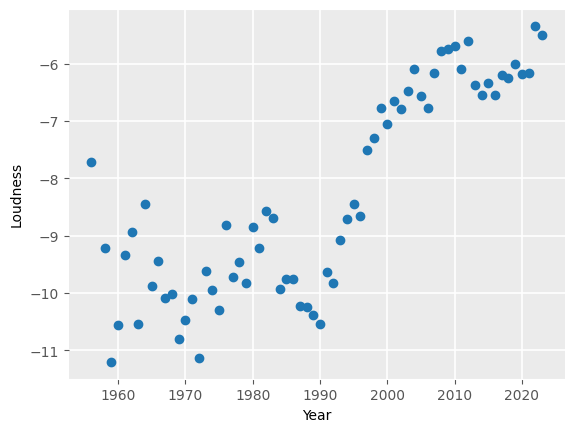

In [78]:
import matplotlib.pyplot as plt

ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.axisbelow':True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'grid.color': 'white',
    'grid.linewidth': '1.2',
    'xtick.color': '555555',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.color': '555555',
    'ytick.major.left': True,
    'ytick.minor.left': False,
}


plt.rcParams.update(ggplot_styles)

plt.scatter(df_loudness['Year'], df_loudness['Loudness'])
plt.xlabel('Year')
plt.ylabel('Loudness');

The range from 1990 to 2000 shows a very swift linear growth, but 2000 onwards the growth is softened, leading to a "halt" on approximately - 6.0 db in 2010 - 2020.

In [79]:
from sklearn.linear_model import LinearRegression

def fit_model(data, feature: str):
    X = data.drop(feature, axis = 1).copy()
    y = data[feature].copy()
    linear_reg = LinearRegression()
    linear_reg.fit(X, y)
    return X, y, linear_reg

#X = df_loudness.drop('Loudness', axis = 1).copy()
#y = df_loudness['Loudness'].copy()

#linear_reg = LinearRegression()
#linear_reg.fit(X, y);

model_1 = fit_model(df_loudness, 'Loudness')
X = model_1[0]
y = model_1[1]
linear_reg = model_1[2]

Try with 7th degree

In [80]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=7, include_bias=False)

X_poly = poly_features.fit_transform(X)

linear_reg.fit(X_poly, y)

y_fit_poly = linear_reg.predict(X_poly)

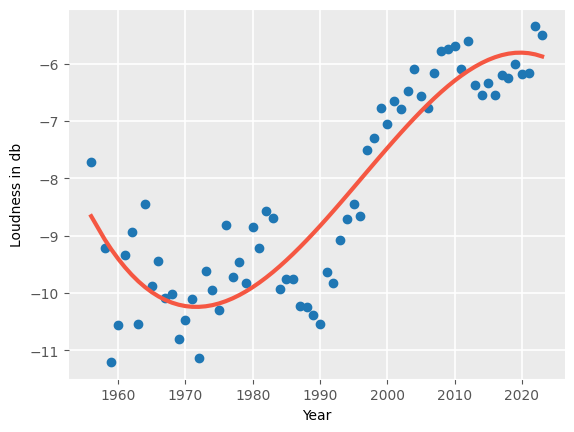

In [81]:
plt.scatter(X, y)
plt.plot(X, y_fit_poly, color = '#f55742', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Loudness in db');

Evaluate model using metrics MSE, RMSE, MAE and R2 Score

In [82]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def evaluate_model(y_test, y_prediction):
    print(f"MSE  : {mean_squared_error(y_test, y_prediction)}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_prediction))}")
    print(f"MAE  : {mean_absolute_error(y_test, y_prediction)}")
    print(f"R² score: {r2_score(y_test, y_prediction)}")
    print('\n\r')

# Get metrics in dB
evaluate_model(y,y_fit_poly)

MSE  : 0.5307763720701124
RMSE : 0.7285440083276455
MAE  : 0.6043476727974897
R² score: 0.8319991016593069




According to this model, after 2020 the average loudness of song should decrease, but this model doesn't ajust so well to the data. So it's going to be used data from 1990 onwards to get a more appropriate model.

In [83]:
df_1990 = df_loudness[df_loudness["Year"]>= 1990].reset_index()
df_1990.drop(columns = 'index', inplace= True)
df_1990.head()

,Year,Loudness
0,1990,-10.54
1,1991,-9.63
2,1992,-9.82
3,1993,-9.08
4,1994,-8.71


In [84]:
model_2 = fit_model(df_1990, 'Loudness')
X = model_2[0]
y = model_2[1]
linear_reg = model_1[2]

In [85]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)

X_poly = poly_features.fit_transform(X)

In [86]:
linear_reg.fit(X_poly, y)

y_fit_poly = linear_reg.predict(X_poly)

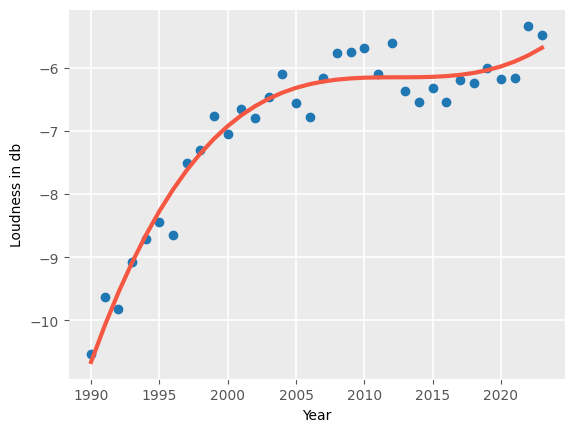

In [87]:
plt.scatter(X, y)
plt.plot(X, y_fit_poly, color = '#f55742', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Loudness in db');

In [88]:
# Get metrics in dB
evaluate_model(y,y_fit_poly)

MSE  : 0.092173681229856
RMSE : 0.303601187793882
MAE  : 0.2462992266061552
R² score: 0.9471265502351115




In [89]:
years_list = [i for i in range(2024, 2031)]
df_future = pd.DataFrame(years_list, columns =['Year'])
df_future.head(10)

,Year
0,2024
1,2025
2,2026
3,2027
4,2028
5,2029
6,2030


In [90]:
df_2000 = df_loudness[df_loudness["Year"]>= 2000].reset_index()
df_2000.drop(columns = 'index', inplace= True)

In [91]:
model_3 = fit_model(df_2000, 'Loudness')
X = model_3[0]
y = model_3[1]
linear_reg = model_3[2]

In [92]:
y_pred_poly = linear_reg.predict(df_future)

In [93]:
# Simulate points with random
from numpy.random import seed
from numpy.random import randint

seed(0)

y_simulation_points = y_pred_poly + 1/10*randint(-5, 5, len(y_pred_poly))

Some randomness is going to be used to visualize and emulate a possible scenario to the future.

In [94]:
y_pred_points = pd.DataFrame(y_simulation_points)

In [95]:
y_pred_points.rename(columns={0: "Loudness_pred"}, inplace= True)
y_pred_points.head(10)

,Loudness_pred
0,-5.773949
1,-6.239532
2,-5.905114
3,-5.870697
4,-5.436280
5,-5.201862
6,-5.767445


In [96]:
y_pred_points['Year'] = df_future

In [97]:
df_predictions = df_1990.merge(y_pred_points, how = 'outer', on = ['Year'])

In [98]:
df_predictions.at[df_predictions.index[df_predictions['Year'] == 2023][0],'Loudness_pred'] = df_predictions.at[df_predictions.index[df_predictions['Year'] == 2023][0],'Loudness']

In [99]:
poly_pred_curve = pd.concat([df_1990, y_pred_points.rename(columns={"Loudness_pred": "Loudness"})])
X = df_1990.drop('Loudness', axis = 1).copy()
X = pd.concat([X, df_future])
y = poly_pred_curve['Loudness'].copy()


In [100]:
from scipy.optimize import curve_fit

X = X.reset_index()
y = y.reset_index()

xdata = X['Year'].to_numpy()
ydata = y['Loudness'].to_numpy()

In [101]:
def log_model(x, a, b, c, d):
    return a * np.log(b * (x-c)) + d

init_vals = [10, 20, 1, 5]
popt, pcov = curve_fit(log_model, xdata, ydata, p0=init_vals)
y_pred = log_model(200, *popt)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18896\1402104984.py:2: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * (x-c)) + d


In [102]:
# Evaluate logarithmic model
evaluate_model(y['Loudness'], log_model(xdata, *popt))

MSE  : 0.17585603327899718
RMSE : 0.41935192056195136
MAE  : 0.3693419387096674
R² score: 0.8940240561240863




C:\Users\Matheus\AppData\Local\Temp\ipykernel_18896\961137958.py:29: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend((historical, prediction),


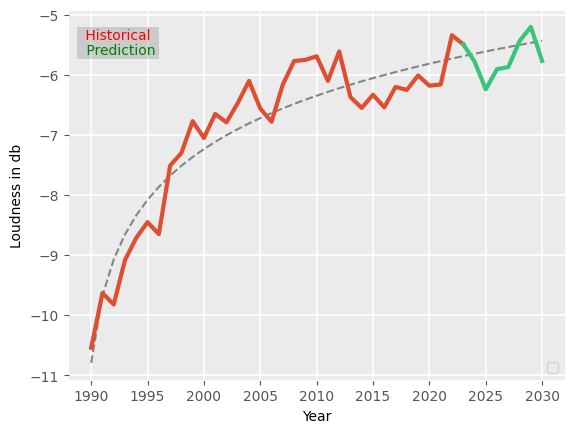

In [103]:
import matplotlib.patches as patches

fig, axs = plt.subplots(1,1)

t1 = axs.text(0.10,0.92, ' Historical ', ha='center', color='red', transform=axs.transAxes)
t2 = axs.text(0.10,0.88, ' Prediction', ha='center', color='green', transform=axs.transAxes)

fig.canvas.draw()

textobjs = [t1,t2]

xmin = min([t.get_window_extent().xmin - 4 for t in textobjs])
xmax = max([t.get_window_extent().xmax + 4 for t in textobjs])
ymin = min([t.get_window_extent().ymin - 2 for t in textobjs])
ymax = max([t.get_window_extent().ymax + 2 for t in textobjs])

xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, facecolor='grey', alpha=0.3, transform=fig.transFigure)

axs.add_patch(rect)

plt.plot(xdata, log_model(xdata, *popt), '--', color = '#7d8a83')
historical = plt.plot(df_predictions['Year'], df_predictions['Loudness'], color = '#de4e31', linewidth = 3)
prediction = plt.plot(df_predictions['Year'], df_predictions['Loudness_pred'], color = '#39c47a', linewidth = 3)
plt.xlabel('Year')
plt.ylabel('Loudness in db')
plt.legend((historical, prediction),
           ('Historical', 'Prediction'),
           loc='lower right',
           ncol=1,
           fontsize=10)
plt.show()

So the prediction according to log model is that songs loudness continues to grow, but with a decreasing growing rate to the next years.

In [104]:
spark.stop()